Comparison and MCMC parameter estimation fitting low-energy eigenvalues of a Woods-Saxon with a square well model.
The WS problem is used to generate "experimental" data which is approximated by the square well solutions.

Log-likelihood requires computing eigenvalues of square well by Lanczos algorithm, which makes MCMC very slow! 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy import integrate
from scipy.sparse.linalg import eigsh

In [138]:
#constants
hbar= 1
mass = 1
L = 20
oam = 0
V0 = 80
R0 = 5
a0 = 0.8
n_max = 100
r_dim = 400
# n_space = 1+np.arange(nmax)
n_space = np.arange(n_max)
r_space = np.linspace(0,L,r_dim)

In [139]:
def basis(r,n):
    y = np.sin((n+1)*np.pi*r/L)
    return np.sqrt(2/L)*y

def KE(n):
    z = hbar*np.pi*n/L
    return 0.5*z*z/mass

def KErot(m,n,l):
    z = hbar*hbar*l*(l+1)*np.pi*np.pi*0.5/(mass*L*L)
    return z*min(m,n)

def square_well(r,r0,v0):
    v = np.zeros(r.shape)
    v[r<r0] = -v0
    return v

def woods_saxon(r,r0,v0,a0):
    v = - v0 / (1 + np.exp((r - r0)/a0))
    return v

def inner_product(x,y,space):
    return integrate.simps(x*y,space)
    
def square_well_int(m,n,r0,v0):
    return inner_product(basis(r_space,m),square_well(r_space,r0,v0)*basis(r_space,n),r_space)
    
def woods_saxon_int(m,n,r0,v0,a0):
    return inner_product(basis(r_space,m),woods_saxon(r_space,r0,v0,a0)*basis(r_space,n),r_space)
    
def fourier_to_coord(wfn_f):
    wfn_r = np.sum([wfn_f[k]*basis(r_space,k) for k in n_space],axis=0)
    return wfn_r

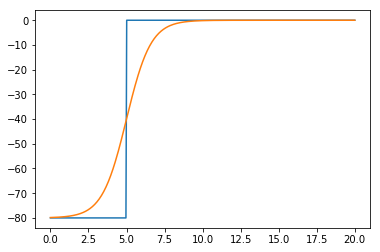

In [140]:
plt.plot(r_space,square_well(r_space,R0,V0))
plt.plot(r_space,woods_saxon(r_space,R0,V0,a0))
plt.show()

In [144]:
def make_T():
        T = np.diag(KE(n_space))
        return T

def make_Trot():
    Trot = np.zeros((n_max,n_max))
    for i in range(n_max):
        for j in range(n_max):
            Trot[i,j] = KErot(i,j,oam)
    return Trot
    
def make_V_sw(params):
    try:
        R0, V0 = params
    except:
        raise Exception('SW PARAMS')
    V_square_well = np.zeros((n_max,n_max))    
    for i in range(n_max):
        for j in range(n_max):
            V_square_well[i,j] = square_well_int(i,j,R0,V0)
    return V_square_well
            
def make_V_ws(params):
    try:
        R0, V0, a0 = params
    except:
        raise Exception('WS PARAMS')
    V_woods_saxon = np.zeros((n_max,n_max))
    for i in range(n_max):
        for j in range(n_max):
            V_woods_saxon[i,j] = woods_saxon_int(i,j,R0,V0,a0)
    return V_woods_saxon

def make_H(int_type,params):
    if int_type == 'sw':
        V = make_V_sw(params)
    elif int_type == 'ws':
        V = make_V_ws(params)
    return make_T() + make_Trot() + V

def eigensolve(H,n_keep):
    evals,evecs = la.eig(H)
#     evals,evecs = eigsh(H,n_keep)
    idx = evals.argsort()[::-1]   
    idx = np.flipud(idx)
    evals = evals[idx]
    evecs = evecs[:,idx]
    return evals[:n_keep], evecs[:,:n_keep]

def model(int_type,params,n_keep):
    H = make_H(int_type,params)
    evals, evecs = eigensolve(H,n_keep)
    return evals

def rmse(x,y,dy):
    return np.sqrt(np.sum(((x-y)/dy)**2)/len(x))

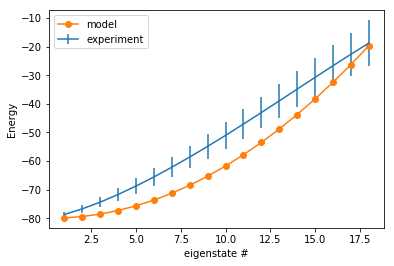

RMSE = 1.967144


In [165]:
exp_params = [R0, V0, a0]
n_keep = 18
k = 2 # number of params in model


exp_data = model('ws',[R0,V0,a0],n_keep)
exp_unc = np.linspace(1,8,exp_data.shape[0])
theory = model('sw',[R0,V0],n_keep)
idx = np.arange(n_keep) + 1
plt.errorbar(idx,exp_data,exp_unc,label='experiment')
plt.plot(idx,theory,'-o',label='model')
plt.ylabel('Energy')
plt.xlabel('eigenstate #')
plt.legend()
# plt.legend(['square well','woods saxon'])
plt.show()
print('RMSE = %f' % rmse(exp_data,theory,exp_unc))

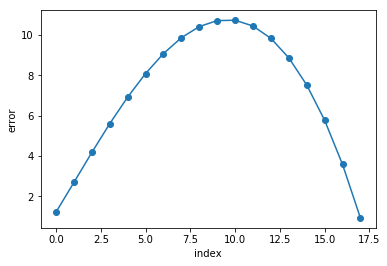

In [168]:
# plot errors
plt.plot(exp_data - theory,'-o')
plt.xlabel('index')
plt.ylabel('error')
plt.show()

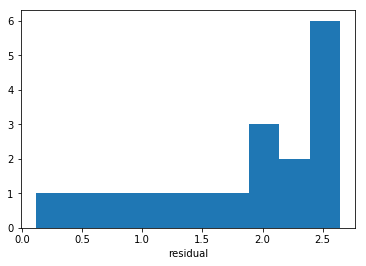

In [169]:
resid = (exp_data - theory) / exp_unc
plt.hist(resid)
plt.xlabel('residual')
plt.show()

In [174]:
from scipy import optimize

def log_likelihood(params,n_keep):
    theory = model('sw',params,n_keep)
    chi_squared = np.sum( (exp - theory)**2 / (unc)**2)
    return   n_keep*( - 0.5 * chi_squared - np.log(np.sqrt(2*np.pi)) ) + np.sum(np.log(unc))

def minfunc(params, n_keep):
    return -log_likelihood(params, n_keep)

result = optimize.minimize(minfunc, x0=[2,50], args=(n_keep), method = 'Nelder-Mead', options = {'disp':True,'maxiter':20})
result

 final_simplex: (array([[ 4.7513916 , 77.10144043],
       [ 4.94267578, 76.11083984],
       [ 4.45820312, 76.00585938]]), array([173.46913404, 210.39885624, 212.76868709]))
           fun: 173.46913404445868
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 39
           nit: 20
        status: 2
       success: False
             x: array([ 4.7513916 , 77.10144043])

In [151]:
def log_prior(params,mu,sigma):
    return -np.sum([0.5* (params[i] - mu[i])**2 / sigma[i]**2 for i in range(k)]) - np.sum(np.sqrt(2*np.pi*sigma))
    
def log_posterior(params, prior_mu, prior_sigma, n_keep):
    return log_prior(params, np.array(prior_mu), np.array(prior_sigma)) + log_likelihood(params, n_keep)/n_keep

In [152]:
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955, 0.997], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    
# Convenience function to extract the peak position of the mode
def max_of_mode(sampler_object):
    max_arg = np.argmax(sampler.flatlnprobability)
    return(sampler.flatchain[max_arg])

In [155]:
### WARNING: THE RESULTS HERE ARE NOT CONVERGEDL!!!

import emcee
print('emcee sampling (version: )', emcee.__version__)

ndim = k  # kmax+1
nwalkers = 10  # number of MCMC walkers
nsteps = 20 # steps per walker
# dtheta = 0.5*np.ones(ndim)    # parameters for prior

print(f'{nwalkers} walkers: {nsteps} samples each')
# print('prior sigmas = '+str(dtheta))

# initialize walkers
starting_guesses = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[[2,50],[5,100],n_keep])
%time sampler.run_mcmc(starting_guesses, nsteps)
print("done")

emcee sampling (version: ) 2.2.1
10 walkers: 20 samples each
Wall time: 9min 28s
done


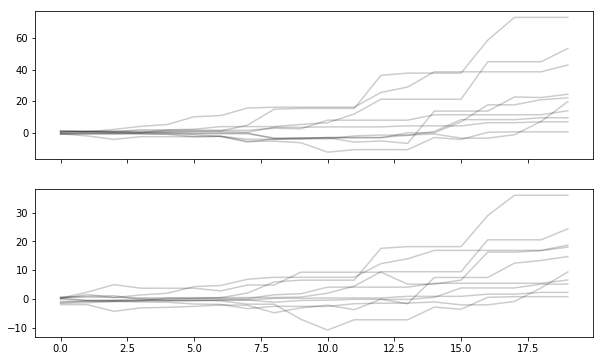

In [156]:
fig, ax = plt.subplots(ndim, sharex=True,figsize=(10,6))
for i in range(ndim):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);

In [160]:
# We choose a warm-up time
nwarmup = 0 # warm up

# sampler.chain is of shape (nwalkers, nsteps, ndim)
# we'll throw-out the warmup points and reshape:
emcee_trace = sampler.chain[:, nwarmup:, :].reshape(-1, ndim).T
emcee_lnprob = sampler.lnprobability[:, nwarmup:].reshape(-1).T

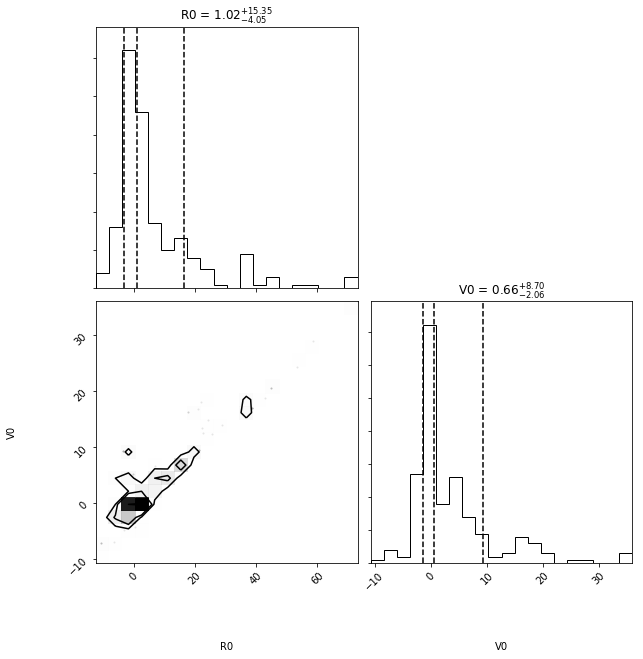

In [161]:
# Alternatively we can use corner
import corner
fig, ax = plt.subplots(ndim,ndim, figsize=(10,10))

def label_func():
    label_list=['R0','V0']
    return label_list

label_list = label_func()
corner.corner(emcee_trace.T,labels=label_list,
                       quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True
                       );